# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


## Sampling

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(2400)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

1    5700
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(500)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 60-40

0    5700
1    3300
Name: label, dtype: int64

0    5700
1    3800
Name: label, dtype: int64

In [6]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(5250, replace=True)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 40-60

0    5700
1    3300
Name: label, dtype: int64

1    8550
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
zeros = df[df["label"]==0].sample(3000)
df = pd.concat((df, zeros))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

0    8700
1    3300
Name: label, dtype: int64

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



In [7]:
from facebook_hateful_memes_detector.utils import in_notebook, CNNHead, MultiLayerTransformerDecoderHead, AveragedLinearHead, OneTokenPositionLinearHead, MultiTaskForward, CNN2DHead
def fb_detr_loss_builder(n_dims, n_tokens, n_out, dropout, loss="classification"):
    loss = "classification" if loss is None else loss
    cnn = MultiLayerTransformerDecoderHead(n_dims, n_tokens, n_out, dropout, 
                                           gaussian_noise=0.0, loss=loss, n_layers=3)
    mtf = MultiTaskForward([cnn])
    return mtf

# Fasttext 1D CNN

In [ ]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel,
                         dict(
                             classifier_dims=256,
                             num_classes=2,
                             n_layers=2,
                             final_layer_builder=fb_1d_loss_builder,
                             gaussian_noise=0.15,
                             dropout=0.2,
                             embedding_dims=256,
                             internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin",
                             featurizer="transformer",
                             loss="focal",
                             dice_loss_coef=0.0,
                             auc_loss_coef=0.0,
                         ),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    model_call_back=reg_sched,
    scheduler_init_fn=scheduler_init_fn,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712

# Lang Features Model

In [ ]:
epochs = 15
batch_size = 256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = [
    "fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"
]  # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = [
    "full_view",
]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.2,
                              embedding_dims=256,
                              internal_dims=512,
                              capabilities=all_caps,
                              featurizer="transformer",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              n_layers=2,
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    show_model_stats=False,
    sampling_policy="without_replacement",
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# BERT Models

## Actibus/Bert_REview

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.778856 LR = 0.00000007



Epoch =  2 Loss = 0.357877 LR = 0.00000014



Epoch =  3 Loss = 0.275952 LR = 0.00000021



Epoch =  4 Loss = 0.242605 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.437  0.437 0.347 0.561       0.004  0.000 0.000 1.000
1.000        0.450  0.450 0.362 0.526       0.014  0.000 0.000 1.000

,Probability,Predictions,Labels
4256,0.408,0.000,0.000
3517,0.421,0.000,0.000
2960,0.479,0.000,1.000
6130,0.431,0.000,0.000
3116,0.455,0.000,1.000
6389,0.425,0.000,0.000
2193,0.407,0.000,0.000
5677,0.481,0.000,1.000
800,0.433,0.000,0.000
2039,0.430,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.438  0.437 0.364 0.530       0.004  0.000 0.000 1.000
1.000        0.448  0.448 0.386 0.537       0.011  0.000 0.000 1.000

,Probability,Predictions,Labels
1532,0.483,0.000,1.000
354,0.476,0.000,0.000
883,0.455,0.000,0.000
1092,0.467,0.000,1.000
509,0.468,0.000,0.000
992,0.479,0.000,1.000
1015,0.478,0.000,1.000
1490,0.424,0.000,0.000
156,0.461,0.000,1.000
194,0.407,0.000,0.000


Epoch =  4 Train = 0.658779 Val = 0.624109



Epoch =  5 Loss = 0.205803 LR = 0.00000035



Epoch =  6 Loss = 0.206606 LR = 0.00000042



Epoch =  7 Loss = 0.209117 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.372  0.372 0.272 0.490       0.000  0.000 0.000 0.000
1.000        0.395  0.394 0.272 0.506       0.001  0.000 0.000 1.000

,Probability,Predictions,Labels
2372,0.388,0.000,1.000
1084,0.321,0.000,1.000
1535,0.388,0.000,0.000
3817,0.425,0.000,0.000
2762,0.353,0.000,1.000
48,0.397,0.000,1.000
6526,0.478,0.000,1.000
1237,0.388,0.000,1.000
4733,0.405,0.000,0.000
750,0.426,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.374  0.372 0.288 0.487       0.000  0.000 0.000 0.000
1.000        0.393  0.391 0.317 0.505       0.002  0.000 0.000 1.000

,Probability,Predictions,Labels
1461,0.457,0.000,0.000
542,0.369,0.000,1.000
1686,0.361,0.000,0.000
532,0.388,0.000,0.000
243,0.396,0.000,1.000
166,0.487,0.000,0.000
937,0.358,0.000,0.000
1596,0.368,0.000,0.000
1193,0.373,0.000,1.000
239,0.455,0.000,0.000


Epoch =  7 Train = 0.691940 Val = 0.665247



Epoch =  8 Loss = 0.206107 LR = 0.00000056



Epoch =  9 Loss = 0.201134 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.357  0.355 0.282 0.503       0.000  0.000 0.000 1.000
1.000        0.383  0.379 0.291 0.517       0.003  0.000 0.000 1.000

,Probability,Predictions,Labels
929,0.384,0.000,1.000
7005,0.356,0.000,1.000
2033,0.427,0.000,1.000
5824,0.394,0.000,1.000
620,0.372,0.000,0.000
4524,0.358,0.000,0.000
6011,0.314,0.000,0.000
3351,0.376,0.000,1.000
5042,0.377,0.000,1.000
3815,0.339,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.359  0.355 0.286 0.506       0.001  0.000 0.000 1.000
1.000        0.380  0.377 0.289 0.529       0.002  0.000 0.000 1.000

,Probability,Predictions,Labels
326,0.415,0.000,1.000
1712,0.370,0.000,0.000
1669,0.417,0.000,1.000
1039,0.368,0.000,1.000
298,0.360,0.000,0.000
1408,0.376,0.000,0.000
342,0.357,0.000,0.000
1772,0.374,0.000,1.000
1268,0.335,0.000,0.000
1181,0.352,0.000,0.000


Epoch =  9 Train = 0.683064 Val = 0.651153



Epoch =  10 Loss = 0.191380 LR = 0.00000069



Epoch =  11 Loss = 0.180688 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.449 0.382 0.686       0.140  0.000 0.000 1.000
1.000        0.496  0.481 0.382 0.699       0.389  0.000 0.000 1.000

,Probability,Predictions,Labels
2591,0.431,0.000,0.000
4594,0.442,0.000,1.000
328,0.674,1.000,0.000
3867,0.519,1.000,1.000
819,0.483,0.000,0.000
4662,0.456,0.000,0.000
5659,0.414,0.000,0.000
4907,0.452,0.000,1.000
4017,0.455,0.000,1.000
2089,0.439,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.464  0.450 0.400 0.693       0.168  0.000 0.000 1.000
1.000        0.492  0.476 0.410 0.683       0.370  0.000 0.000 1.000

,Probability,Predictions,Labels
573,0.452,0.000,0.000
1213,0.449,0.000,1.000
513,0.441,0.000,1.000
1318,0.420,0.000,0.000
233,0.557,1.000,1.000
25,0.442,0.000,0.000
1446,0.433,0.000,1.000
525,0.493,0.000,0.000
359,0.437,0.000,0.000
470,0.440,0.000,0.000


Epoch =  11 Train = 0.701310 Val = 0.670603



Epoch =  12 Loss = 0.174914 LR = 0.00000083



Epoch =  13 Loss = 0.173324 LR = 0.00000090



Epoch =  14 Loss = 0.175846 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.455  0.449 0.412 0.580       0.064  0.000 0.000 1.000
1.000        0.477  0.462 0.418 0.592       0.251  0.000 0.000 1.000

,Probability,Predictions,Labels
290,0.451,0.000,1.000
4644,0.449,0.000,0.000
70,0.444,0.000,0.000
6797,0.451,0.000,0.000
566,0.435,0.000,1.000
525,0.437,0.000,1.000
1868,0.448,0.000,1.000
5503,0.448,0.000,0.000
2704,0.445,0.000,0.000
574,0.444,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.456  0.449 0.423 0.579       0.077  0.000 0.000 1.000
1.000        0.474  0.458 0.431 0.583       0.230  0.000 0.000 1.000

,Probability,Predictions,Labels
94,0.435,0.000,1.000
544,0.446,0.000,0.000
1052,0.438,0.000,0.000
1603,0.432,0.000,0.000
847,0.440,0.000,0.000
1595,0.452,0.000,0.000
83,0.448,0.000,0.000
337,0.501,1.000,1.000
1797,0.442,0.000,0.000
1071,0.445,0.000,0.000


Epoch =  14 Train = 0.713879 Val = 0.687887



Epoch =  15 Loss = 0.172766 LR = 0.00000100



Epoch =  16 Loss = 0.168945 LR = 0.00000099



Epoch =  17 Loss = 0.170408 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.468 0.390 0.718       0.275  0.000 0.000 1.000
1.000        0.538  0.524 0.405 0.739       0.603  1.000 0.000 1.000

,Probability,Predictions,Labels
3911,0.648,1.000,1.000
364,0.438,0.000,0.000
2759,0.474,0.000,1.000
3701,0.479,0.000,1.000
3319,0.456,0.000,0.000
5303,0.574,1.000,1.000
1110,0.543,1.000,1.000
1754,0.620,1.000,1.000
3552,0.494,0.000,0.000
5560,0.451,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.488  0.470 0.407 0.708       0.287  0.000 0.000 1.000
1.000        0.533  0.516 0.423 0.723       0.594  1.000 0.000 1.000

,Probability,Predictions,Labels
596,0.431,0.000,0.000
1651,0.460,0.000,0.000
756,0.669,1.000,0.000
1142,0.455,0.000,0.000
31,0.470,0.000,0.000
478,0.485,0.000,1.000
1725,0.465,0.000,0.000
540,0.525,1.000,0.000
452,0.456,0.000,0.000
953,0.473,0.000,0.000


Epoch =  17 Train = 0.727338 Val = 0.700114



Epoch =  18 Loss = 0.166632 LR = 0.00000097



Epoch =  19 Loss = 0.168797 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.476  0.470 0.359 0.656       0.266  0.000 0.000 1.000
1.000        0.526  0.522 0.374 0.673       0.595  1.000 0.000 1.000

,Probability,Predictions,Labels
26,0.640,1.000,1.000
4138,0.518,1.000,0.000
949,0.465,0.000,0.000
490,0.483,0.000,0.000
1544,0.454,0.000,0.000
5636,0.426,0.000,0.000
3746,0.410,0.000,0.000
1470,0.539,1.000,0.000
5666,0.451,0.000,1.000
406,0.460,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.472 0.376 0.661       0.284  0.000 0.000 1.000
1.000        0.521  0.512 0.385 0.669       0.571  1.000 0.000 1.000

,Probability,Predictions,Labels
490,0.604,1.000,1.000
40,0.434,0.000,1.000
841,0.427,0.000,1.000
1207,0.445,0.000,1.000
1444,0.464,0.000,0.000
913,0.454,0.000,0.000
1744,0.470,0.000,1.000
511,0.422,0.000,0.000
1080,0.587,1.000,0.000
686,0.435,0.000,0.000


Epoch =  19 Train = 0.725775 Val = 0.698195



Epoch =  20 Loss = 0.167020 LR = 0.00000093



Epoch =  21 Loss = 0.165427 LR = 0.00000091



Epoch =  22 Loss = 0.164196 LR = 0.00000088



Epoch =  23 Loss = 0.164969 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.463 0.362 0.673       0.155  0.000 0.000 1.000
1.000        0.521  0.488 0.381 0.681       0.474  0.000 0.000 1.000

,Probability,Predictions,Labels
4053,0.466,0.000,1.000
5822,0.416,0.000,0.000
5261,0.414,0.000,0.000
2481,0.462,0.000,1.000
5394,0.437,0.000,0.000
4403,0.459,0.000,0.000
3168,0.465,0.000,0.000
3710,0.455,0.000,0.000
6424,0.632,1.000,1.000
4243,0.402,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.469  0.463 0.380 0.672       0.163  0.000 0.000 1.000
1.000        0.517  0.486 0.384 0.678       0.455  0.000 0.000 1.000

,Probability,Predictions,Labels
940,0.463,0.000,1.000
1758,0.416,0.000,0.000
337,0.434,0.000,0.000
1604,0.463,0.000,0.000
1153,0.464,0.000,0.000
1266,0.572,1.000,0.000
1244,0.455,0.000,1.000
903,0.450,0.000,1.000
408,0.463,0.000,1.000
1018,0.607,1.000,1.000


Epoch =  23 Train = 0.737059 Val = 0.721016



Epoch =  24 Loss = 0.168154 LR = 0.00000081



Epoch =  25 Loss = 0.169057 LR = 0.00000077



Epoch =  26 Loss = 0.161662 LR = 0.00000073



Epoch =  27 Loss = 0.167067 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.460  0.451 0.432 0.607       0.091  0.000 0.000 1.000
1.000        0.494  0.468 0.439 0.613       0.391  0.000 0.000 1.000

,Probability,Predictions,Labels
5659,0.549,1.000,1.000
1545,0.452,0.000,0.000
3542,0.449,0.000,0.000
893,0.451,0.000,1.000
1924,0.451,0.000,0.000
5165,0.451,0.000,0.000
6244,0.452,0.000,0.000
3167,0.448,0.000,0.000
1524,0.450,0.000,0.000
1539,0.525,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.451 0.437 0.606       0.105  0.000 0.000 1.000
1.000        0.492  0.463 0.440 0.608       0.371  0.000 0.000 1.000

,Probability,Predictions,Labels
545,0.599,1.000,1.000
536,0.450,0.000,0.000
696,0.451,0.000,0.000
268,0.451,0.000,0.000
1396,0.451,0.000,1.000
67,0.507,1.000,0.000
919,0.452,0.000,1.000
677,0.447,0.000,0.000
1327,0.448,0.000,0.000
1309,0.451,0.000,0.000


Epoch =  27 Train = 0.739219 Val = 0.728222



Epoch =  28 Loss = 0.165453 LR = 0.00000065



Epoch =  29 Loss = 0.166828 LR = 0.00000060



Epoch =  30 Loss = 0.164578 LR = 0.00000056



Epoch =  31 Loss = 0.164046 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.456  0.441 0.399 0.643       0.130  0.000 0.000 1.000
1.000        0.507  0.485 0.407 0.659       0.459  0.000 0.000 1.000

,Probability,Predictions,Labels
2278,0.504,1.000,0.000
6767,0.441,0.000,0.000
3033,0.437,0.000,0.000
386,0.468,0.000,0.000
2714,0.593,1.000,1.000
4592,0.444,0.000,0.000
6427,0.442,0.000,0.000
1362,0.511,1.000,0.000
5492,0.613,1.000,1.000
2613,0.478,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.441 0.406 0.652       0.146  0.000 0.000 1.000
1.000        0.504  0.482 0.412 0.656       0.438  0.000 0.000 1.000

,Probability,Predictions,Labels
209,0.443,0.000,0.000
100,0.500,1.000,0.000
1682,0.414,0.000,0.000
180,0.612,1.000,1.000
524,0.442,0.000,0.000
12,0.442,0.000,0.000
246,0.552,1.000,1.000
473,0.447,0.000,1.000
436,0.589,1.000,1.000
634,0.624,1.000,1.000


Epoch =  31 Train = 0.751765 Val = 0.737348



Epoch =  32 Loss = 0.162326 LR = 0.00000046



Epoch =  33 Loss = 0.163775 LR = 0.00000042



Epoch =  34 Loss = 0.158461 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.443  0.432 0.334 0.654       0.186  0.000 0.000 1.000
1.000        0.514  0.511 0.344 0.673       0.539  1.000 0.000 1.000

,Probability,Predictions,Labels
2804,0.431,0.000,0.000
3069,0.392,0.000,0.000
555,0.571,1.000,0.000
4976,0.507,1.000,1.000
4426,0.534,1.000,1.000
704,0.496,0.000,1.000
3171,0.478,0.000,0.000
1952,0.479,0.000,1.000
5777,0.574,1.000,0.000
452,0.471,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.446  0.433 0.342 0.659       0.193  0.000 0.000 1.000
1.000        0.511  0.509 0.355 0.667       0.532  1.000 0.000 1.000

,Probability,Predictions,Labels
784,0.427,0.000,1.000
300,0.385,0.000,0.000
718,0.567,1.000,0.000
391,0.367,0.000,0.000
1677,0.416,0.000,0.000
1597,0.359,0.000,0.000
1725,0.511,1.000,0.000
862,0.382,0.000,0.000
472,0.530,1.000,0.000
719,0.382,0.000,0.000


Epoch =  34 Train = 0.755351 Val = 0.741592



Epoch =  35 Loss = 0.162133 LR = 0.00000033



Epoch =  36 Loss = 0.159756 LR = 0.00000028



Epoch =  37 Loss = 0.161835 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.456  0.436 0.356 0.672       0.189  0.000 0.000 1.000
1.000        0.522  0.513 0.370 0.703       0.549  1.000 0.000 1.000

,Probability,Predictions,Labels
3197,0.435,0.000,0.000
3023,0.474,0.000,1.000
634,0.472,0.000,1.000
6081,0.437,0.000,0.000
3522,0.562,1.000,1.000
3298,0.434,0.000,0.000
6303,0.430,0.000,1.000
5997,0.530,1.000,0.000
3015,0.457,0.000,1.000
524,0.475,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.459  0.436 0.367 0.686       0.192  0.000 0.000 1.000
1.000        0.519  0.510 0.382 0.687       0.545  1.000 0.000 1.000

,Probability,Predictions,Labels
423,0.512,1.000,1.000
271,0.505,1.000,0.000
1572,0.392,0.000,0.000
163,0.407,0.000,0.000
869,0.605,1.000,1.000
1762,0.475,0.000,0.000
1418,0.431,0.000,0.000
191,0.483,0.000,0.000
991,0.435,0.000,1.000
1150,0.497,0.000,1.000


Epoch =  37 Train = 0.757717 Val = 0.742032



Epoch =  38 Loss = 0.163075 LR = 0.00000020



Epoch =  39 Loss = 0.160042 LR = 0.00000017



Epoch =  40 Loss = 0.160857 LR = 0.00000013



Epoch =  41 Loss = 0.162422 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.464  0.447 0.354 0.698       0.214  0.000 0.000 1.000
1.000        0.535  0.526 0.371 0.731       0.583  1.000 0.000 1.000

,Probability,Predictions,Labels
6110,0.538,1.000,0.000
1179,0.444,0.000,0.000
410,0.396,0.000,0.000
4883,0.482,0.000,0.000
3814,0.526,1.000,1.000
6428,0.641,1.000,1.000
1561,0.589,1.000,1.000
4276,0.449,0.000,0.000
5789,0.477,0.000,1.000
7023,0.618,1.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.467  0.447 0.368 0.710       0.221  0.000 0.000 1.000
1.000        0.531  0.520 0.381 0.712       0.591  1.000 0.000 1.000

,Probability,Predictions,Labels
1669,0.444,0.000,0.000
993,0.448,0.000,0.000
899,0.447,0.000,1.000
1341,0.608,1.000,1.000
391,0.460,0.000,0.000
617,0.518,1.000,0.000
1482,0.509,1.000,0.000
77,0.441,0.000,0.000
640,0.504,1.000,0.000
698,0.468,0.000,0.000


Epoch =  41 Train = 0.760496 Val = 0.744837



Epoch =  42 Loss = 0.163685 LR = 0.00000008



Epoch =  43 Loss = 0.160610 LR = 0.00000005



Epoch =  44 Loss = 0.160670 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.449 0.339 0.697       0.243  0.000 0.000 1.000
1.000        0.541  0.537 0.360 0.739       0.620  1.000 0.000 1.000

,Probability,Predictions,Labels
5213,0.449,0.000,0.000
497,0.593,1.000,1.000
5968,0.470,0.000,0.000
3004,0.475,0.000,1.000
5118,0.449,0.000,0.000
3385,0.418,0.000,0.000
3412,0.422,0.000,1.000
2574,0.610,1.000,1.000
3598,0.375,0.000,1.000
5822,0.467,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.469  0.449 0.354 0.715       0.247  0.000 0.000 1.000
1.000        0.536  0.532 0.368 0.721       0.618  1.000 0.000 1.000

,Probability,Predictions,Labels
705,0.426,0.000,0.000
1038,0.618,1.000,1.000
1129,0.408,0.000,0.000
296,0.610,1.000,1.000
985,0.426,0.000,0.000
323,0.475,0.000,1.000
244,0.554,1.000,0.000
1242,0.614,1.000,1.000
1311,0.448,0.000,0.000
1715,0.620,1.000,1.000


Epoch =  44 Train = 0.761098 Val = 0.744870



Epoch =  45 Loss = 0.159562 LR = 0.00000002



Epoch =  46 Loss = 0.159488 LR = 0.00000001



Epoch =  47 Loss = 0.158642 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.469  0.450 0.334 0.714       0.274  0.000 0.000 1.000
1.000        0.550  0.548 0.355 0.756       0.651  1.000 0.000 1.000

,Probability,Predictions,Labels
6003,0.372,0.000,0.000
6255,0.562,1.000,1.000
1511,0.419,0.000,0.000
4783,0.513,1.000,1.000
5449,0.621,1.000,1.000
5189,0.629,1.000,1.000
2053,0.498,0.000,0.000
2966,0.626,1.000,1.000
1118,0.562,1.000,1.000
1033,0.401,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.450 0.349 0.732       0.275  0.000 0.000 1.000
1.000        0.545  0.543 0.363 0.739       0.652  1.000 0.000 1.000

,Probability,Predictions,Labels
672,0.697,1.000,1.000
978,0.525,1.000,1.000
1041,0.490,0.000,0.000
217,0.387,0.000,0.000
59,0.508,1.000,0.000
638,0.448,0.000,0.000
1072,0.622,1.000,1.000
1585,0.452,0.000,0.000
1570,0.460,0.000,1.000
1532,0.553,1.000,0.000


Epoch =  47 Train = 0.761055 Val = 0.744720



Epoch =  48 Loss = 0.160892 LR = 0.00000000



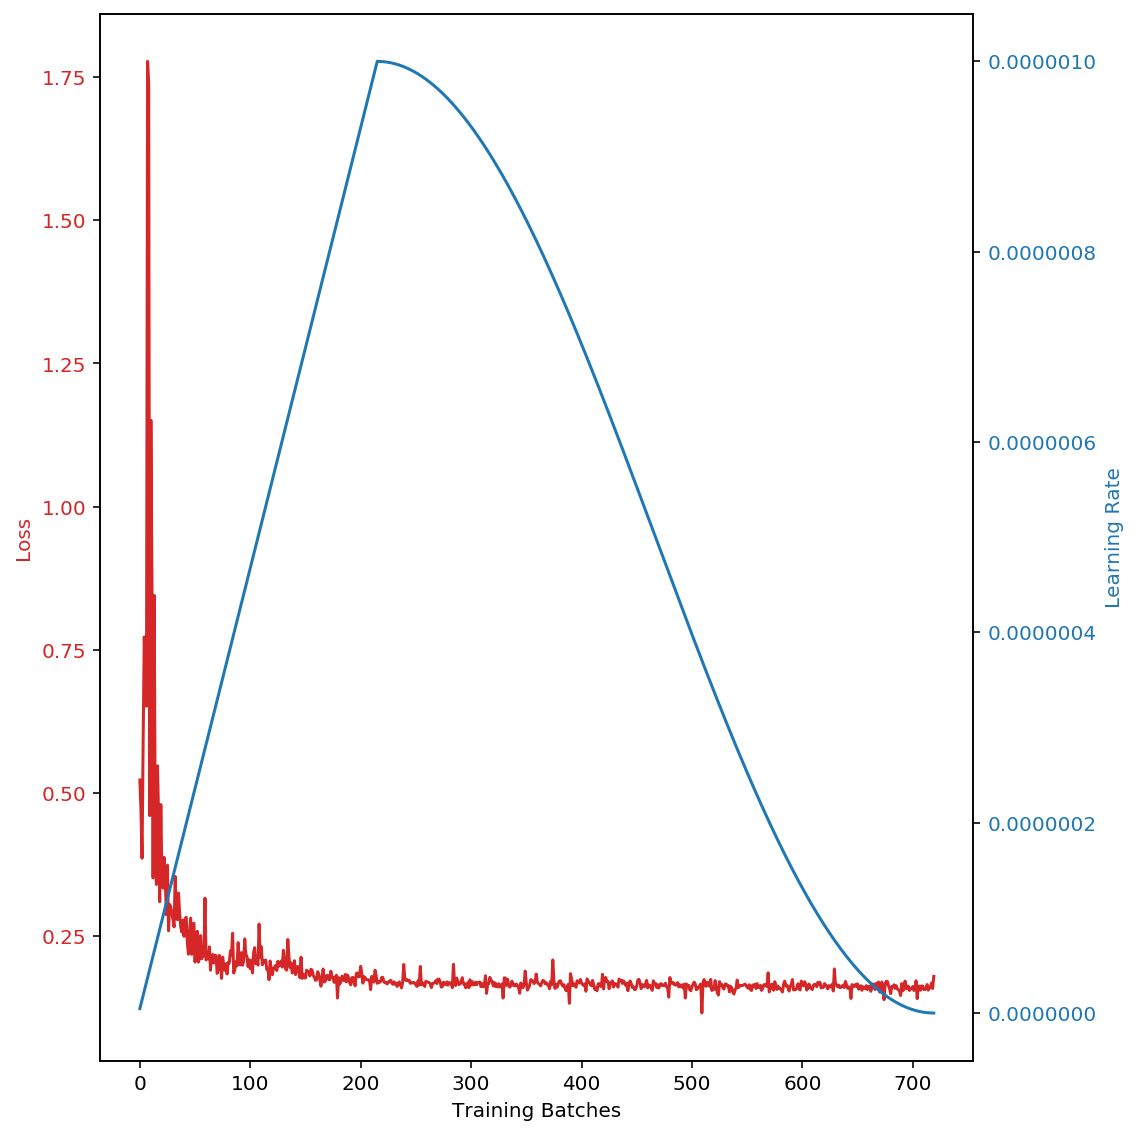

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.450 0.349 0.732       0.274  0.000 0.000 1.000
1.000        0.545  0.543 0.363 0.739       0.650  1.000 0.000 1.000

,Probability,Predictions,Labels
1426,0.363,0.000,1.000
126,0.448,0.000,0.000
586,0.396,0.000,1.000
5,0.436,0.000,0.000
1118,0.446,0.000,1.000
1514,0.494,0.000,1.000
575,0.434,0.000,0.000
1708,0.393,0.000,1.000
341,0.501,1.000,0.000
70,0.506,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.469  0.450 0.333 0.714       0.273  0.000 0.000 1.000
1.000        0.550  0.548 0.355 0.757       0.650  1.000 0.000 1.000

,Probability,Predictions,Labels
59,0.655,1.000,0.000
2848,0.640,1.000,0.000
5496,0.463,0.000,1.000
6908,0.450,0.000,0.000
5353,0.614,1.000,1.000
1115,0.426,0.000,0.000
673,0.644,1.000,1.000
5532,0.600,1.000,0.000
5899,0.582,1.000,1.000
5770,0.458,0.000,1.000


train   val
mean_or_std metric               
mean        map       0.670 0.624
            accuracy  0.699 0.698
            auc       0.761 0.745
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.782  0.727 0.754 4560.000     0.782  0.726 0.753 1140.000
pos     0.580  0.650 0.613 2640.000     0.579  0.650 0.612  660.000

In [8]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review",
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.734 (0.707	0.696)


## NSP Style Finetuned

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 1.172570 LR = 0.00000007



Epoch =  2 Loss = 0.448051 LR = 0.00000014



Epoch =  3 Loss = 0.296903 LR = 0.00000021



Epoch =  4 Loss = 0.263882 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.421  0.420 0.395 0.466       0.000  0.000 0.000 0.000
1.000        0.425  0.424 0.396 0.460       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
2936,0.415,0.000,0.000
1456,0.419,0.000,0.000
58,0.433,0.000,0.000
4591,0.416,0.000,0.000
1432,0.417,0.000,0.000
5156,0.409,0.000,0.000
4194,0.423,0.000,0.000
4188,0.412,0.000,0.000
3389,0.419,0.000,0.000
2793,0.429,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.421  0.420 0.399 0.468       0.000  0.000 0.000 0.000
1.000        0.424  0.424 0.400 0.470       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1100,0.432,0.000,1.000
1584,0.419,0.000,0.000
1023,0.423,0.000,1.000
1379,0.427,0.000,0.000
932,0.412,0.000,0.000
1,0.437,0.000,1.000
1212,0.435,0.000,0.000
869,0.427,0.000,1.000
1582,0.422,0.000,1.000
1086,0.432,0.000,0.000


Epoch =  4 Train = 0.618752 Val = 0.609339


Exception for:  keyboard | ' ' ' ' | ['word_cutout' 'char_insert' 'one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  5 Loss = 0.239773 LR = 0.00000035



Epoch =  6 Loss = 0.229140 LR = 0.00000042



Epoch =  7 Loss = 0.210020 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.540  0.540 0.512 0.578       1.000  1.000 1.000 1.000
1.000        0.544  0.544 0.516 0.578       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
773,0.552,1.000,0.000
6375,0.540,1.000,1.000
213,0.544,1.000,0.000
2468,0.549,1.000,0.000
3466,0.534,1.000,0.000
115,0.536,1.000,0.000
1411,0.534,1.000,0.000
3784,0.554,1.000,0.000
2852,0.556,1.000,0.000
2119,0.527,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.541  0.540 0.520 0.571       1.000  1.000 1.000 1.000
1.000        0.545  0.544 0.517 0.579       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
323,0.533,1.000,0.000
1716,0.545,1.000,0.000
547,0.541,1.000,0.000
1348,0.532,1.000,0.000
1743,0.549,1.000,0.000
574,0.538,1.000,0.000
1252,0.539,1.000,0.000
1310,0.548,1.000,0.000
118,0.550,1.000,0.000
142,0.533,1.000,0.000


Epoch =  7 Train = 0.628672 Val = 0.627489



Epoch =  8 Loss = 0.202231 LR = 0.00000056



Epoch =  9 Loss = 0.208481 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.410  0.410 0.386 0.453       0.000  0.000 0.000 0.000
1.000        0.415  0.415 0.388 0.461       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
6200,0.415,0.000,1.000
5301,0.396,0.000,1.000
4776,0.403,0.000,0.000
161,0.404,0.000,0.000
856,0.404,0.000,0.000
1155,0.415,0.000,0.000
5106,0.411,0.000,0.000
6333,0.404,0.000,0.000
4232,0.406,0.000,0.000
1018,0.425,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.411  0.410 0.387 0.442       0.000  0.000 0.000 0.000
1.000        0.415  0.415 0.388 0.456       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1068,0.413,0.000,0.000
418,0.399,0.000,0.000
1798,0.419,0.000,1.000
958,0.417,0.000,1.000
925,0.428,0.000,1.000
1478,0.432,0.000,0.000
1006,0.412,0.000,0.000
1143,0.407,0.000,0.000
246,0.403,0.000,0.000
139,0.401,0.000,1.000


Epoch =  9 Train = 0.647516 Val = 0.634519



Epoch =  10 Loss = 0.205151 LR = 0.00000069



Epoch =  11 Loss = 0.190524 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.388  0.387 0.363 0.422       0.000  0.000 0.000 0.000
1.000        0.392  0.392 0.367 0.423       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
4625,0.391,0.000,0.000
753,0.394,0.000,1.000
3754,0.378,0.000,0.000
5594,0.378,0.000,0.000
5070,0.396,0.000,1.000
3090,0.390,0.000,1.000
1644,0.384,0.000,0.000
4407,0.394,0.000,1.000
5174,0.384,0.000,1.000
2368,0.382,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.388  0.388 0.368 0.415       0.000  0.000 0.000 0.000
1.000        0.392  0.392 0.364 0.423       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1687,0.394,0.000,0.000
857,0.390,0.000,1.000
1313,0.399,0.000,1.000
1535,0.388,0.000,0.000
1397,0.396,0.000,1.000
1113,0.385,0.000,0.000
835,0.380,0.000,0.000
807,0.387,0.000,1.000
1683,0.379,0.000,0.000
379,0.403,0.000,1.000


Epoch =  11 Train = 0.644942 Val = 0.633220



Epoch =  12 Loss = 0.203845 LR = 0.00000083



Epoch =  13 Loss = 0.196110 LR = 0.00000090



Epoch =  14 Loss = 0.186066 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.490  0.489 0.403 0.584       0.393  0.000 0.000 1.000
1.000        0.509  0.511 0.411 0.588       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
3584,0.554,1.000,1.000
4152,0.449,0.000,0.000
1830,0.478,0.000,0.000
5076,0.491,0.000,1.000
4616,0.519,1.000,0.000
471,0.444,0.000,0.000
567,0.447,0.000,0.000
2185,0.500,0.000,0.000
4439,0.489,0.000,1.000
2166,0.539,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.491  0.490 0.416 0.573       0.400  0.000 0.000 1.000
1.000        0.508  0.511 0.411 0.587       0.603  1.000 0.000 1.000

,Probability,Predictions,Labels
1219,0.523,1.000,0.000
6,0.549,1.000,1.000
1205,0.511,1.000,1.000
1176,0.454,0.000,1.000
570,0.530,1.000,1.000
471,0.444,0.000,1.000
1004,0.465,0.000,0.000
1170,0.468,0.000,0.000
1705,0.534,1.000,1.000
887,0.486,0.000,1.000


Epoch =  14 Train = 0.648128 Val = 0.635315



Epoch =  15 Loss = 0.182890 LR = 0.00000100



Epoch =  16 Loss = 0.179778 LR = 0.00000099



Epoch =  17 Loss = 0.183716 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.483  0.480 0.429 0.566       0.265  0.000 0.000 1.000
1.000        0.501  0.503 0.433 0.569       0.541  1.000 0.000 1.000

,Probability,Predictions,Labels
2209,0.497,0.000,1.000
6039,0.467,0.000,0.000
6438,0.475,0.000,0.000
255,0.453,0.000,0.000
1391,0.450,0.000,1.000
3985,0.526,1.000,0.000
4195,0.526,1.000,1.000
4970,0.504,1.000,1.000
3776,0.535,1.000,0.000
5062,0.461,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.482 0.433 0.568       0.273  0.000 0.000 1.000
1.000        0.501  0.502 0.434 0.565       0.527  1.000 0.000 1.000

,Probability,Predictions,Labels
1239,0.477,0.000,1.000
691,0.484,0.000,0.000
91,0.509,1.000,1.000
194,0.518,1.000,1.000
110,0.543,1.000,1.000
396,0.519,1.000,0.000
1475,0.456,0.000,0.000
1721,0.486,0.000,1.000
298,0.518,1.000,1.000
1224,0.501,1.000,0.000


Epoch =  17 Train = 0.688498 Val = 0.672431



Epoch =  18 Loss = 0.175307 LR = 0.00000097



Epoch =  19 Loss = 0.170251 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.460 0.402 0.636       0.216  0.000 0.000 1.000
1.000        0.513  0.508 0.404 0.642       0.539  1.000 0.000 1.000

,Probability,Predictions,Labels
1850,0.485,0.000,0.000
4662,0.483,0.000,1.000
6095,0.568,1.000,0.000
6955,0.534,1.000,0.000
1463,0.458,0.000,1.000
6184,0.449,0.000,0.000
1256,0.468,0.000,1.000
1451,0.464,0.000,1.000
856,0.473,0.000,1.000
4133,0.505,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.462 0.403 0.642       0.221  0.000 0.000 1.000
1.000        0.513  0.503 0.407 0.637       0.526  1.000 0.000 1.000

,Probability,Predictions,Labels
766,0.449,0.000,1.000
1505,0.564,1.000,0.000
1510,0.417,0.000,0.000
250,0.458,0.000,1.000
310,0.458,0.000,1.000
1698,0.534,1.000,1.000
616,0.447,0.000,0.000
1438,0.552,1.000,0.000
298,0.411,0.000,0.000
204,0.436,0.000,0.000


Epoch =  19 Train = 0.724270 Val = 0.710122



Epoch =  20 Loss = 0.168645 LR = 0.00000093



Epoch =  21 Loss = 0.168592 LR = 0.00000091



Epoch =  22 Loss = 0.165793 LR = 0.00000088



Epoch =  23 Loss = 0.167767 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.455  0.436 0.394 0.591       0.196  0.000 0.000 1.000
1.000        0.504  0.518 0.397 0.598       0.544  1.000 0.000 1.000

,Probability,Predictions,Labels
3705,0.462,0.000,0.000
1429,0.545,1.000,0.000
3608,0.432,0.000,0.000
575,0.579,1.000,1.000
4451,0.437,0.000,0.000
1228,0.433,0.000,0.000
3450,0.552,1.000,0.000
1369,0.540,1.000,1.000
123,0.548,1.000,1.000
5656,0.421,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.438 0.395 0.586       0.214  0.000 0.000 1.000
1.000        0.503  0.512 0.400 0.598       0.533  1.000 0.000 1.000

,Probability,Predictions,Labels
1476,0.520,1.000,0.000
717,0.463,0.000,1.000
1118,0.567,1.000,1.000
323,0.433,0.000,1.000
1374,0.408,0.000,0.000
418,0.503,1.000,0.000
79,0.407,0.000,0.000
924,0.434,0.000,1.000
1373,0.428,0.000,0.000
143,0.457,0.000,1.000


Epoch =  23 Train = 0.740138 Val = 0.724673



Epoch =  24 Loss = 0.164263 LR = 0.00000081



Epoch =  25 Loss = 0.167155 LR = 0.00000077



Epoch =  26 Loss = 0.162040 LR = 0.00000073



Epoch =  27 Loss = 0.162767 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.437  0.416 0.367 0.599       0.169  0.000 0.000 1.000
1.000        0.499  0.507 0.372 0.603       0.517  1.000 0.000 1.000

,Probability,Predictions,Labels
1430,0.392,0.000,0.000
4434,0.374,0.000,0.000
2783,0.577,1.000,1.000
4913,0.413,0.000,0.000
3326,0.415,0.000,0.000
1095,0.452,0.000,1.000
4581,0.378,0.000,0.000
6435,0.588,1.000,1.000
1116,0.404,0.000,0.000
1187,0.466,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.441  0.419 0.365 0.596       0.193  0.000 0.000 1.000
1.000        0.499  0.510 0.376 0.602       0.527  1.000 0.000 1.000

,Probability,Predictions,Labels
1728,0.419,0.000,0.000
929,0.558,1.000,0.000
1217,0.506,1.000,0.000
1333,0.381,0.000,0.000
1678,0.413,0.000,1.000
895,0.433,0.000,1.000
1713,0.473,0.000,1.000
249,0.556,1.000,0.000
600,0.377,0.000,0.000
40,0.392,0.000,0.000


Epoch =  27 Train = 0.752057 Val = 0.734929



Epoch =  28 Loss = 0.163241 LR = 0.00000065



Epoch =  29 Loss = 0.159261 LR = 0.00000060



Epoch =  30 Loss = 0.161112 LR = 0.00000056



Epoch =  31 Loss = 0.159323 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.441  0.426 0.329 0.619       0.181  0.000 0.000 1.000
1.000        0.511  0.516 0.345 0.624       0.548  1.000 0.000 1.000

,Probability,Predictions,Labels
156,0.366,0.000,0.000
388,0.442,0.000,0.000
3311,0.438,0.000,0.000
3521,0.381,0.000,0.000
1089,0.610,1.000,0.000
3438,0.569,1.000,0.000
2585,0.407,0.000,0.000
5404,0.477,0.000,1.000
3193,0.603,1.000,0.000
2873,0.426,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.446  0.431 0.329 0.618       0.201  0.000 0.000 1.000
1.000        0.509  0.513 0.352 0.624       0.536  1.000 0.000 1.000

,Probability,Predictions,Labels
1646,0.616,1.000,1.000
1412,0.477,0.000,0.000
981,0.569,1.000,1.000
1465,0.446,0.000,0.000
1162,0.600,1.000,1.000
1748,0.465,0.000,1.000
1279,0.381,0.000,0.000
1569,0.426,0.000,0.000
405,0.575,1.000,0.000
1531,0.440,0.000,0.000


Epoch =  31 Train = 0.759620 Val = 0.736903



Epoch =  32 Loss = 0.160796 LR = 0.00000046



Epoch =  33 Loss = 0.163553 LR = 0.00000042



Epoch =  34 Loss = 0.161724 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.459  0.448 0.329 0.624       0.215  0.000 0.000 1.000
1.000        0.528  0.534 0.356 0.628       0.600  1.000 0.000 1.000

,Probability,Predictions,Labels
4177,0.478,0.000,0.000
5385,0.575,1.000,1.000
677,0.452,0.000,0.000
6348,0.386,0.000,0.000
3978,0.397,0.000,0.000
5124,0.442,0.000,0.000
4532,0.441,0.000,0.000
2072,0.399,0.000,0.000
16,0.603,1.000,1.000
1735,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.464  0.453 0.330 0.622       0.241  0.000 0.000 1.000
1.000        0.526  0.532 0.369 0.626       0.597  1.000 0.000 1.000

,Probability,Predictions,Labels
698,0.478,0.000,0.000
1746,0.383,0.000,0.000
500,0.409,0.000,0.000
1253,0.478,0.000,0.000
503,0.410,0.000,0.000
889,0.431,0.000,0.000
1068,0.554,1.000,1.000
973,0.476,0.000,0.000
805,0.407,0.000,0.000
161,0.548,1.000,1.000


Epoch =  34 Train = 0.765022 Val = 0.740406



Epoch =  35 Loss = 0.159198 LR = 0.00000033



Epoch =  36 Loss = 0.160290 LR = 0.00000028



Epoch =  37 Loss = 0.160195 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.461  0.451 0.329 0.632       0.216  0.000 0.000 1.000
1.000        0.530  0.535 0.363 0.636       0.612  1.000 0.000 1.000

,Probability,Predictions,Labels
60,0.583,1.000,0.000
6163,0.450,0.000,0.000
4691,0.348,0.000,0.000
6454,0.521,1.000,0.000
1007,0.577,1.000,0.000
5560,0.607,1.000,1.000
4748,0.552,1.000,0.000
6259,0.459,0.000,0.000
710,0.462,0.000,1.000
2822,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.455 0.332 0.628       0.246  0.000 0.000 1.000
1.000        0.528  0.532 0.376 0.636       0.592  1.000 0.000 1.000

,Probability,Predictions,Labels
299,0.386,0.000,0.000
661,0.465,0.000,0.000
722,0.480,0.000,0.000
291,0.592,1.000,1.000
326,0.619,1.000,1.000
4,0.538,1.000,0.000
963,0.426,0.000,0.000
1299,0.391,0.000,0.000
1506,0.458,0.000,1.000
151,0.474,0.000,1.000


Epoch =  37 Train = 0.768798 Val = 0.742675



Epoch =  38 Loss = 0.157420 LR = 0.00000020



Epoch =  39 Loss = 0.160227 LR = 0.00000017



Epoch =  40 Loss = 0.161024 LR = 0.00000013



Epoch =  41 Loss = 0.160153 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.474  0.462 0.319 0.652       0.299  0.000 0.000 1.000
1.000        0.554  0.570 0.351 0.657       0.706  1.000 0.000 1.000

,Probability,Predictions,Labels
5110,0.548,1.000,0.000
257,0.433,0.000,0.000
925,0.446,0.000,1.000
3225,0.388,0.000,0.000
1908,0.592,1.000,1.000
5791,0.481,0.000,0.000
691,0.436,0.000,1.000
1226,0.480,0.000,0.000
4630,0.623,1.000,1.000
3328,0.411,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.469 0.322 0.650       0.329  0.000 0.000 1.000
1.000        0.551  0.569 0.368 0.657       0.683  1.000 0.000 1.000

,Probability,Predictions,Labels
822,0.442,0.000,0.000
1374,0.633,1.000,0.000
635,0.380,0.000,0.000
111,0.652,1.000,1.000
236,0.541,1.000,1.000
668,0.474,0.000,1.000
1552,0.501,1.000,0.000
307,0.536,1.000,1.000
1669,0.385,0.000,0.000
312,0.438,0.000,0.000


Epoch =  41 Train = 0.771398 Val = 0.744032



Epoch =  42 Loss = 0.157518 LR = 0.00000008



Epoch =  43 Loss = 0.162114 LR = 0.00000005



Epoch =  44 Loss = 0.156563 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.453 0.318 0.647       0.275  0.000 0.000 1.000
1.000        0.546  0.563 0.346 0.652       0.685  1.000 0.000 1.000

,Probability,Predictions,Labels
3293,0.629,1.000,0.000
4636,0.613,1.000,1.000
2038,0.399,0.000,0.000
3654,0.456,0.000,0.000
3720,0.493,0.000,0.000
4644,0.420,0.000,0.000
3942,0.622,1.000,1.000
3458,0.533,1.000,0.000
3807,0.447,0.000,0.000
2846,0.477,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.460 0.322 0.645       0.302  0.000 0.000 1.000
1.000        0.543  0.562 0.363 0.652       0.664  1.000 0.000 1.000

,Probability,Predictions,Labels
1727,0.523,1.000,0.000
1276,0.479,0.000,1.000
824,0.499,0.000,1.000
139,0.384,0.000,0.000
881,0.433,0.000,0.000
944,0.639,1.000,1.000
494,0.566,1.000,0.000
1419,0.402,0.000,1.000
269,0.486,0.000,0.000
182,0.630,1.000,1.000


Epoch =  44 Train = 0.772472 Val = 0.743868



Epoch =  45 Loss = 0.157083 LR = 0.00000002



Epoch =  46 Loss = 0.160376 LR = 0.00000001



Epoch =  47 Loss = 0.157133 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.447 0.304 0.654       0.270  0.000 0.000 1.000
1.000        0.547  0.565 0.332 0.659       0.681  1.000 0.000 1.000

,Probability,Predictions,Labels
1373,0.531,1.000,1.000
278,0.397,0.000,0.000
7103,0.457,0.000,0.000
5646,0.586,1.000,1.000
1607,0.397,0.000,0.000
1338,0.494,0.000,0.000
2219,0.580,1.000,0.000
4417,0.374,0.000,0.000
3003,0.559,1.000,1.000
5888,0.505,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.454 0.308 0.652       0.294  0.000 0.000 1.000
1.000        0.544  0.563 0.356 0.659       0.661  1.000 0.000 1.000

,Probability,Predictions,Labels
726,0.479,0.000,1.000
1549,0.600,1.000,1.000
1526,0.523,1.000,1.000
724,0.608,1.000,0.000
1363,0.616,1.000,0.000
1168,0.552,1.000,1.000
482,0.624,1.000,1.000
1331,0.480,0.000,0.000
446,0.425,0.000,0.000
1694,0.525,1.000,0.000


Epoch =  47 Train = 0.772702 Val = 0.743893



Epoch =  48 Loss = 0.159122 LR = 0.00000000



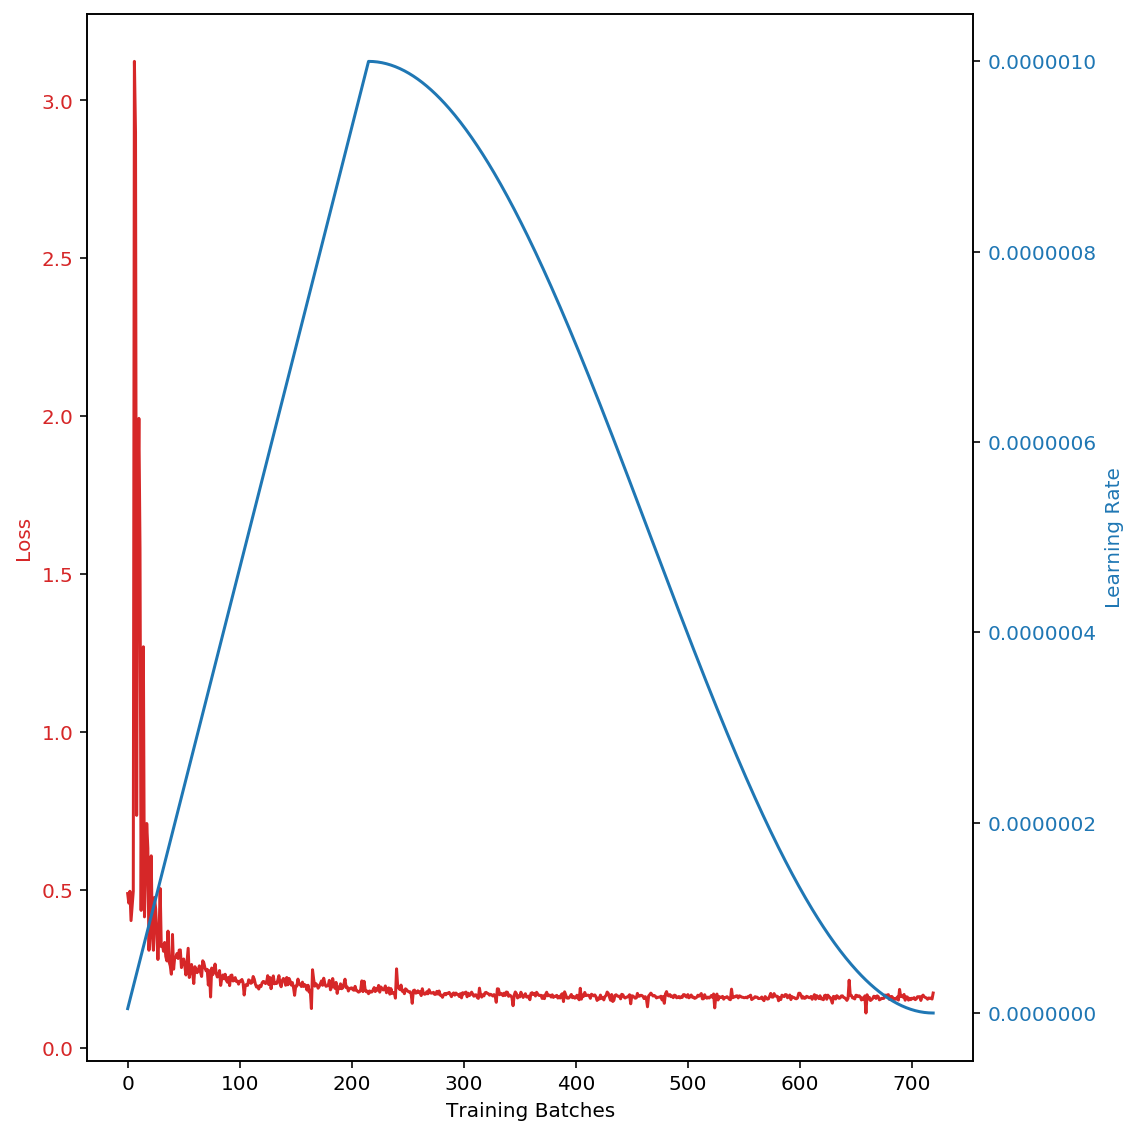

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.454 0.308 0.652       0.291  0.000 0.000 1.000
1.000        0.543  0.563 0.356 0.659       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
1148,0.436,0.000,0.000
1514,0.370,0.000,0.000
1049,0.476,0.000,0.000
1698,0.409,0.000,0.000
1608,0.397,0.000,0.000
478,0.474,0.000,0.000
816,0.453,0.000,1.000
105,0.410,0.000,0.000
814,0.470,0.000,0.000
195,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.447 0.304 0.654       0.270  0.000 0.000 1.000
1.000        0.547  0.565 0.332 0.659       0.680  1.000 0.000 1.000

,Probability,Predictions,Labels
2034,0.368,0.000,0.000
5965,0.391,0.000,0.000
5307,0.505,1.000,0.000
1163,0.603,1.000,0.000
346,0.436,0.000,1.000
5209,0.492,0.000,1.000
2290,0.556,1.000,0.000
6047,0.379,0.000,0.000
3604,0.583,1.000,1.000
1701,0.425,0.000,0.000


train   val
mean_or_std metric               
mean        map       0.660 0.629
            accuracy  0.712 0.691
            auc       0.773 0.744
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.798  0.730 0.762 4560.000     0.782  0.709 0.744 1140.000
pos     0.593  0.680 0.634 2640.000     0.567  0.659 0.610  660.000

In [14]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.25,
                              dropout=0.1,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



### DETR Style

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.529112 LR = 0.00000007


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'one_third_cut' 'keyboard' 'text_rotate'] argument of type 'NoneType' is not iterable

Epoch =  2 Loss = 0.233975 LR = 0.00000014



Epoch =  3 Loss = 0.206990 LR = 0.00000021



Epoch =  4 Loss = 0.198637 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.518 0.537       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.518 0.537       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
436,0.528,1.000,0.000
1900,0.527,1.000,0.000
4201,0.528,1.000,0.000
3465,0.524,1.000,0.000
5136,0.521,1.000,0.000
6707,0.525,1.000,0.000
4285,0.527,1.000,1.000
6057,0.524,1.000,1.000
1672,0.526,1.000,1.000
5643,0.523,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.519 0.535       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.520 0.539       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
1208,0.524,1.000,0.000
1428,0.527,1.000,0.000
716,0.525,1.000,0.000
452,0.524,1.000,0.000
122,0.526,1.000,0.000
117,0.526,1.000,0.000
1039,0.527,1.000,1.000
1403,0.534,1.000,0.000
591,0.527,1.000,0.000
1772,0.526,1.000,0.000


Epoch =  4 Train = 0.605838 Val = 0.594082



Epoch =  5 Loss = 0.205126 LR = 0.00000035



Epoch =  6 Loss = 0.198211 LR = 0.00000042



Epoch =  7 Loss = 0.197796 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.430       0.000  0.000 0.000 0.000
1.000        0.417  0.416 0.406 0.431       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
6413,0.417,0.000,1.000
6060,0.414,0.000,0.000
3516,0.418,0.000,0.000
6858,0.410,0.000,0.000
646,0.413,0.000,1.000
2968,0.424,0.000,0.000
3564,0.415,0.000,0.000
2014,0.423,0.000,1.000
1206,0.415,0.000,0.000
5735,0.415,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.428       0.000  0.000 0.000 0.000
1.000        0.417  0.417 0.407 0.432       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1082,0.418,0.000,0.000
1029,0.408,0.000,0.000
1725,0.415,0.000,0.000
1473,0.416,0.000,1.000
553,0.420,0.000,0.000
223,0.413,0.000,0.000
884,0.414,0.000,0.000
941,0.420,0.000,0.000
1759,0.415,0.000,1.000
1755,0.411,0.000,1.000


Epoch =  7 Train = 0.626044 Val = 0.620737



Epoch =  8 Loss = 0.212310 LR = 0.00000056



Epoch =  9 Loss = 0.189995 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.494 0.506       0.137  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.265  0.000 0.000 1.000

,Probability,Predictions,Labels
5862,0.498,0.000,0.000
5122,0.497,0.000,1.000
1406,0.498,0.000,0.000
5083,0.500,1.000,1.000
3765,0.497,0.000,1.000
1565,0.500,0.000,0.000
5627,0.496,0.000,1.000
5716,0.498,0.000,1.000
5736,0.498,0.000,1.000
5733,0.497,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.493 0.505       0.164  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.267  0.000 0.000 1.000

,Probability,Predictions,Labels
1548,0.500,1.000,0.000
1331,0.496,0.000,1.000
1633,0.498,0.000,0.000
1037,0.504,1.000,0.000
36,0.495,0.000,1.000
442,0.502,1.000,1.000
71,0.498,0.000,1.000
1017,0.495,0.000,1.000
663,0.496,0.000,0.000
1394,0.500,1.000,0.000


Epoch =  9 Train = 0.624843 Val = 0.617760



Epoch =  10 Loss = 0.184634 LR = 0.00000069



Epoch =  11 Loss = 0.180349 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.457  0.457 0.445 0.476       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.446 0.477       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1900,0.465,0.000,1.000
2993,0.452,0.000,0.000
1904,0.457,0.000,0.000
6487,0.457,0.000,1.000
5029,0.459,0.000,0.000
6796,0.452,0.000,0.000
3516,0.460,0.000,0.000
3427,0.471,0.000,1.000
3158,0.453,0.000,0.000
3320,0.459,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.457 0.445 0.474       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.447 0.478       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1765,0.465,0.000,1.000
476,0.464,0.000,1.000
728,0.456,0.000,0.000
1673,0.454,0.000,0.000
1351,0.451,0.000,1.000
9,0.460,0.000,0.000
402,0.447,0.000,1.000
111,0.451,0.000,0.000
835,0.461,0.000,0.000
338,0.464,0.000,0.000


Epoch =  11 Train = 0.636357 Val = 0.632468



Epoch =  12 Loss = 0.177390 LR = 0.00000083



Epoch =  13 Loss = 0.183543 LR = 0.00000090



Epoch =  14 Loss = 0.175410 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.477 0.444 0.512       0.215  0.000 0.000 1.000
1.000        0.492  0.498 0.445 0.513       0.468  0.000 0.000 1.000

,Probability,Predictions,Labels
3114,0.462,0.000,0.000
572,0.472,0.000,0.000
2374,0.512,1.000,1.000
4062,0.468,0.000,0.000
6468,0.485,0.000,0.000
6787,0.464,0.000,1.000
1501,0.479,0.000,0.000
6551,0.509,1.000,0.000
4546,0.467,0.000,0.000
5999,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.480 0.444 0.513       0.245  0.000 0.000 1.000
1.000        0.493  0.499 0.449 0.513       0.479  0.000 0.000 1.000

,Probability,Predictions,Labels
626,0.472,0.000,0.000
1570,0.478,0.000,0.000
1026,0.511,1.000,0.000
170,0.447,0.000,0.000
1439,0.467,0.000,1.000
342,0.494,0.000,0.000
1171,0.461,0.000,0.000
1260,0.510,1.000,0.000
867,0.474,0.000,0.000
1037,0.464,0.000,1.000


Epoch =  14 Train = 0.680606 Val = 0.666915



Epoch =  15 Loss = 0.173379 LR = 0.00000100



Epoch =  16 Loss = 0.170412 LR = 0.00000099



Epoch =  17 Loss = 0.167970 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.468 0.460 0.542       0.178  0.000 0.000 1.000
1.000        0.499  0.501 0.461 0.545       0.506  1.000 0.000 1.000

,Probability,Predictions,Labels
194,0.465,0.000,1.000
6708,0.538,1.000,1.000
5928,0.497,0.000,0.000
3145,0.520,1.000,0.000
555,0.521,1.000,1.000
4944,0.478,0.000,0.000
3072,0.513,1.000,0.000
62,0.467,0.000,0.000
3306,0.466,0.000,1.000
4272,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.469 0.461 0.541       0.189  0.000 0.000 1.000
1.000        0.499  0.503 0.461 0.542       0.518  1.000 0.000 1.000

,Probability,Predictions,Labels
858,0.525,1.000,0.000
1782,0.463,0.000,0.000
138,0.464,0.000,0.000
1526,0.501,1.000,0.000
194,0.465,0.000,0.000
1044,0.520,1.000,0.000
89,0.522,1.000,1.000
282,0.467,0.000,0.000
450,0.530,1.000,1.000
115,0.469,0.000,1.000


Epoch =  17 Train = 0.737272 Val = 0.716143



Epoch =  18 Loss = 0.162094 LR = 0.00000097



Epoch =  19 Loss = 0.170884 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.478 0.466 0.505       0.031  0.000 0.000 1.000
1.000        0.490  0.494 0.466 0.505       0.171  0.000 0.000 1.000

,Probability,Predictions,Labels
6251,0.470,0.000,0.000
5759,0.469,0.000,0.000
2815,0.495,0.000,1.000
6383,0.477,0.000,0.000
6635,0.495,0.000,1.000
1363,0.477,0.000,1.000
5430,0.493,0.000,1.000
3618,0.492,0.000,1.000
3378,0.473,0.000,0.000
3011,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.479 0.466 0.504       0.040  0.000 0.000 1.000
1.000        0.490  0.494 0.467 0.505       0.188  0.000 0.000 1.000

,Probability,Predictions,Labels
717,0.485,0.000,0.000
176,0.497,0.000,1.000
1539,0.494,0.000,1.000
1723,0.502,1.000,1.000
190,0.501,1.000,1.000
1483,0.498,0.000,1.000
141,0.480,0.000,0.000
1742,0.487,0.000,0.000
97,0.493,0.000,1.000
1619,0.475,0.000,0.000


Epoch =  19 Train = 0.737997 Val = 0.714369



Epoch =  20 Loss = 0.171040 LR = 0.00000093



Epoch =  21 Loss = 0.166163 LR = 0.00000091



Epoch =  22 Loss = 0.164707 LR = 0.00000088



Epoch =  23 Loss = 0.163739 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.465 0.462 0.548       0.061  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.553       0.285  0.000 0.000 1.000

,Probability,Predictions,Labels
2562,0.465,0.000,0.000
4142,0.465,0.000,0.000
1283,0.468,0.000,1.000
6862,0.464,0.000,0.000
5377,0.463,0.000,0.000
1624,0.525,1.000,1.000
1601,0.466,0.000,1.000
5120,0.468,0.000,0.000
2460,0.463,0.000,0.000
6271,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.471  0.465 0.462 0.546       0.071  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.552       0.295  0.000 0.000 1.000

,Probability,Predictions,Labels
1355,0.466,0.000,0.000
1605,0.534,1.000,0.000
762,0.468,0.000,0.000
912,0.465,0.000,0.000
496,0.472,0.000,0.000
1537,0.464,0.000,0.000
108,0.467,0.000,0.000
96,0.512,1.000,1.000
1200,0.466,0.000,0.000
1620,0.478,0.000,0.000


Epoch =  23 Train = 0.750888 Val = 0.714731



Epoch =  24 Loss = 0.163177 LR = 0.00000081



Epoch =  25 Loss = 0.161844 LR = 0.00000077



Epoch =  26 Loss = 0.161801 LR = 0.00000073



Epoch =  27 Loss = 0.160937 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.458 0.450 0.556       0.110  0.000 0.000 1.000
1.000        0.495  0.486 0.450 0.557       0.429  0.000 0.000 1.000

,Probability,Predictions,Labels
5054,0.515,1.000,1.000
7105,0.534,1.000,1.000
7110,0.496,0.000,0.000
3110,0.453,0.000,0.000
6450,0.545,1.000,1.000
2616,0.454,0.000,0.000
6022,0.464,0.000,1.000
2349,0.460,0.000,1.000
2145,0.465,0.000,0.000
4640,0.476,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.459 0.450 0.556       0.135  0.000 0.000 1.000
1.000        0.495  0.485 0.451 0.557       0.421  0.000 0.000 1.000

,Probability,Predictions,Labels
1521,0.476,0.000,1.000
1227,0.505,1.000,0.000
379,0.452,0.000,0.000
64,0.514,1.000,1.000
1392,0.453,0.000,0.000
178,0.452,0.000,0.000
701,0.486,0.000,1.000
1516,0.455,0.000,0.000
1690,0.455,0.000,0.000
1241,0.530,1.000,0.000


Epoch =  27 Train = 0.755219 Val = 0.715837



Epoch =  28 Loss = 0.162766 LR = 0.00000065



Epoch =  29 Loss = 0.160942 LR = 0.00000060



Epoch =  30 Loss = 0.161022 LR = 0.00000056



Epoch =  31 Loss = 0.163285 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.478 0.451 0.550       0.174  0.000 0.000 1.000
1.000        0.506  0.507 0.452 0.553       0.551  1.000 0.000 1.000

,Probability,Predictions,Labels
3502,0.472,0.000,0.000
296,0.463,0.000,0.000
5446,0.528,1.000,0.000
5296,0.542,1.000,0.000
5833,0.535,1.000,0.000
3604,0.507,1.000,1.000
6812,0.481,0.000,0.000
2239,0.537,1.000,1.000
2597,0.481,0.000,0.000
1229,0.470,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.480 0.451 0.551       0.203  0.000 0.000 1.000
1.000        0.506  0.506 0.453 0.552       0.542  1.000 0.000 1.000

,Probability,Predictions,Labels
1180,0.491,0.000,0.000
1515,0.456,0.000,1.000
471,0.514,1.000,0.000
906,0.492,0.000,1.000
424,0.470,0.000,0.000
1585,0.500,0.000,0.000
28,0.541,1.000,1.000
1581,0.547,1.000,1.000
1234,0.531,1.000,1.000
737,0.475,0.000,0.000


Epoch =  31 Train = 0.761365 Val = 0.723143



Epoch =  32 Loss = 0.160758 LR = 0.00000046



Epoch =  33 Loss = 0.157157 LR = 0.00000042



Epoch =  34 Loss = 0.162217 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.468 0.428 0.560       0.113  0.000 0.000 1.000
1.000        0.499  0.493 0.428 0.563       0.447  0.000 0.000 1.000

,Probability,Predictions,Labels
6502,0.500,0.000,0.000
1663,0.543,1.000,1.000
6071,0.439,0.000,1.000
51,0.457,0.000,0.000
6714,0.465,0.000,1.000
852,0.431,0.000,0.000
3553,0.511,1.000,0.000
3919,0.488,0.000,0.000
1966,0.486,0.000,0.000
6162,0.535,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.472 0.428 0.561       0.138  0.000 0.000 1.000
1.000        0.498  0.493 0.428 0.562       0.438  0.000 0.000 1.000

,Probability,Predictions,Labels
301,0.457,0.000,0.000
290,0.449,0.000,0.000
1428,0.486,0.000,1.000
1249,0.554,1.000,1.000
666,0.443,0.000,0.000
724,0.478,0.000,1.000
1609,0.482,0.000,0.000
1499,0.518,1.000,0.000
1217,0.541,1.000,1.000
1115,0.446,0.000,0.000


Epoch =  34 Train = 0.766584 Val = 0.725936



Epoch =  35 Loss = 0.158309 LR = 0.00000033



Epoch =  36 Loss = 0.156998 LR = 0.00000028



Epoch =  37 Loss = 0.160969 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.475 0.452 0.558       0.213  0.000 0.000 1.000
1.000        0.511  0.514 0.452 0.560       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
4151,0.514,1.000,1.000
5554,0.533,1.000,1.000
5280,0.479,0.000,0.000
1397,0.479,0.000,1.000
1553,0.500,0.000,1.000
5211,0.461,0.000,0.000
1535,0.514,1.000,0.000
2055,0.459,0.000,0.000
1253,0.548,1.000,1.000
6534,0.486,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.452 0.559       0.246  0.000 0.000 1.000
1.000        0.510  0.514 0.453 0.559       0.597  1.000 0.000 1.000

,Probability,Predictions,Labels
1698,0.457,0.000,0.000
5,0.539,1.000,1.000
185,0.541,1.000,1.000
981,0.467,0.000,0.000
585,0.483,0.000,0.000
1029,0.465,0.000,0.000
1236,0.468,0.000,1.000
41,0.459,0.000,0.000
1568,0.460,0.000,0.000
215,0.495,0.000,0.000


Epoch =  37 Train = 0.769649 Val = 0.727301



Epoch =  38 Loss = 0.159147 LR = 0.00000020



Epoch =  39 Loss = 0.158496 LR = 0.00000017



Epoch =  40 Loss = 0.160286 LR = 0.00000013



Epoch =  41 Loss = 0.159812 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.473 0.437 0.571       0.212  0.000 0.000 1.000
1.000        0.514  0.516 0.437 0.573       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
5005,0.470,0.000,0.000
2726,0.470,0.000,0.000
2704,0.511,1.000,1.000
4693,0.449,0.000,0.000
6558,0.482,0.000,1.000
2785,0.485,0.000,0.000
4155,0.491,0.000,0.000
7112,0.453,0.000,1.000
542,0.460,0.000,0.000
5914,0.459,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.479 0.437 0.571       0.234  0.000 0.000 1.000
1.000        0.512  0.515 0.438 0.572       0.595  1.000 0.000 1.000

,Probability,Predictions,Labels
329,0.568,1.000,1.000
1245,0.568,1.000,1.000
252,0.456,0.000,0.000
1677,0.449,0.000,0.000
1523,0.485,0.000,0.000
1154,0.464,0.000,0.000
253,0.493,0.000,1.000
1207,0.562,1.000,1.000
172,0.475,0.000,0.000
533,0.451,0.000,0.000


Epoch =  41 Train = 0.771929 Val = 0.727091



Epoch =  42 Loss = 0.158031 LR = 0.00000008


Exception for:  keyboard | '' '' | ['half_cut' 'sentence_shuffle' 'word_cutout' 'keyboard' 'stopword_insert'] argument of type 'NoneType' is not iterable

Epoch =  43 Loss = 0.155354 LR = 0.00000005



Epoch =  44 Loss = 0.156557 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.476  0.465 0.430 0.584       0.229  0.000 0.000 1.000
1.000        0.520  0.525 0.431 0.585       0.632  1.000 0.000 1.000

,Probability,Predictions,Labels
6448,0.490,0.000,1.000
3000,0.540,1.000,1.000
4915,0.473,0.000,0.000
53,0.582,1.000,1.000
3092,0.485,0.000,1.000
6474,0.583,1.000,1.000
5065,0.481,0.000,0.000
2628,0.503,1.000,1.000
367,0.444,0.000,1.000
611,0.486,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.470 0.430 0.585       0.255  0.000 0.000 1.000
1.000        0.517  0.522 0.431 0.585       0.611  1.000 0.000 1.000

,Probability,Predictions,Labels
1369,0.447,0.000,0.000
1493,0.553,1.000,0.000
330,0.510,1.000,0.000
1450,0.471,0.000,0.000
953,0.460,0.000,0.000
333,0.577,1.000,1.000
936,0.529,1.000,1.000
894,0.525,1.000,1.000
1442,0.438,0.000,0.000
1192,0.497,0.000,0.000


Epoch =  44 Train = 0.772742 Val = 0.726326



Epoch =  45 Loss = 0.159630 LR = 0.00000002



Epoch =  46 Loss = 0.157575 LR = 0.00000001



Epoch =  47 Loss = 0.158281 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.258  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
5562,0.522,1.000,0.000
6479,0.486,0.000,1.000
2846,0.527,1.000,1.000
4907,0.513,1.000,0.000
7,0.495,0.000,1.000
3935,0.530,1.000,0.000
3540,0.456,0.000,0.000
2287,0.472,0.000,0.000
3606,0.473,0.000,0.000
130,0.440,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.522  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
1638,0.478,0.000,0.000
423,0.495,0.000,1.000
710,0.454,0.000,0.000
236,0.543,1.000,1.000
191,0.493,0.000,0.000
1219,0.499,0.000,0.000
962,0.442,0.000,0.000
1395,0.486,0.000,0.000
1335,0.473,0.000,0.000
1394,0.483,0.000,0.000


Epoch =  47 Train = 0.773144 Val = 0.726743



Epoch =  48 Loss = 0.154522 LR = 0.00000000



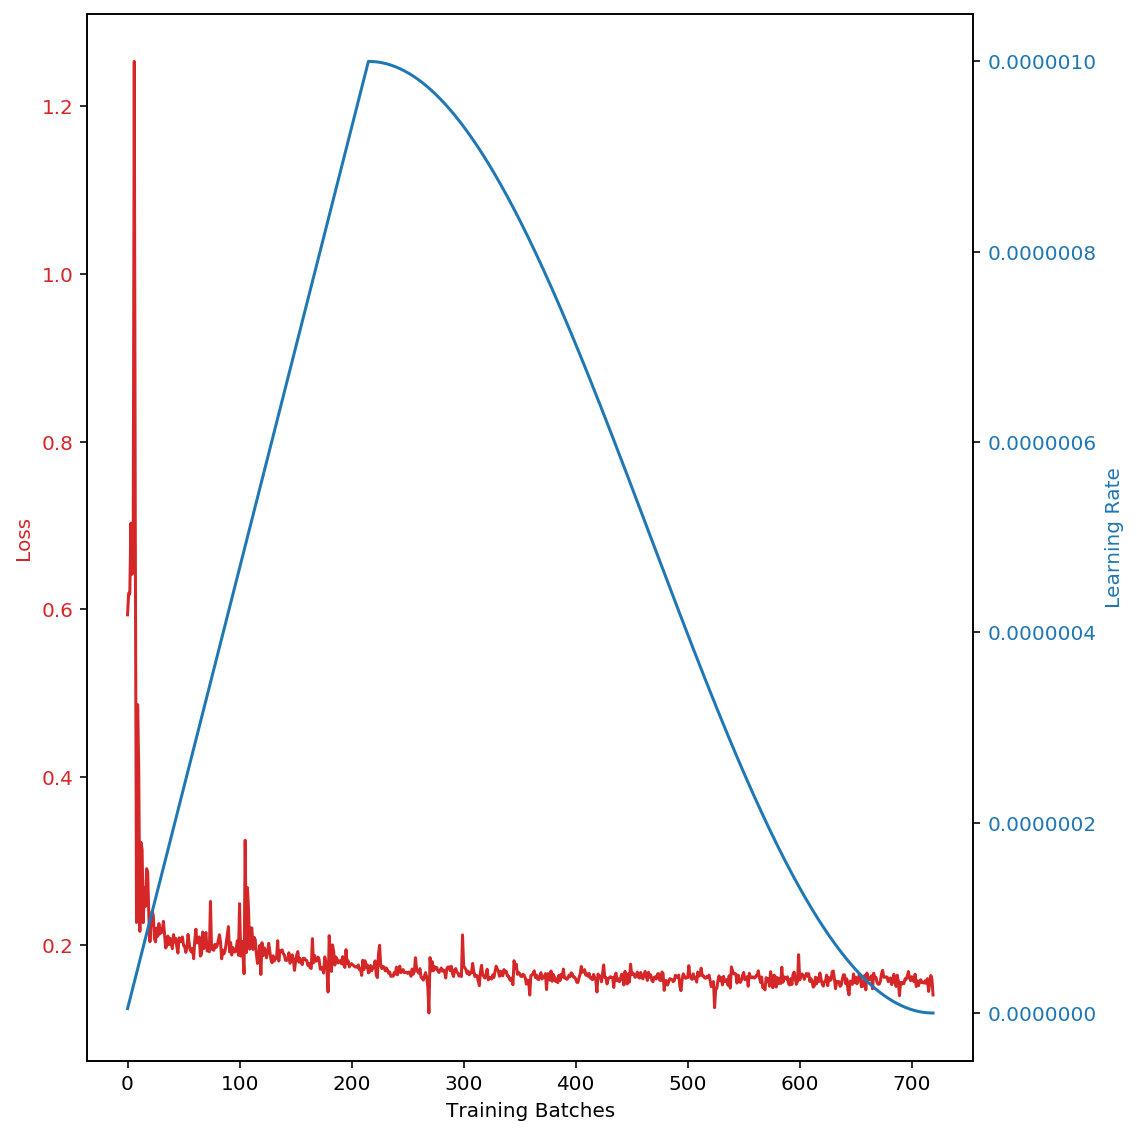

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.521  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
431,0.579,1.000,0.000
1220,0.470,0.000,0.000
1205,0.443,0.000,0.000
697,0.463,0.000,0.000
934,0.459,0.000,1.000
1231,0.436,0.000,0.000
501,0.443,0.000,0.000
1188,0.502,1.000,1.000
1300,0.563,1.000,0.000
554,0.452,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.257  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
2349,0.482,0.000,1.000
6532,0.448,0.000,0.000
2011,0.487,0.000,1.000
7189,0.562,1.000,1.000
2411,0.453,0.000,0.000
4437,0.519,1.000,0.000
6179,0.440,0.000,0.000
1396,0.486,0.000,1.000
4780,0.439,0.000,1.000
6313,0.486,0.000,1.000


train   val
mean_or_std metric               
mean        map       0.665 0.625
            accuracy  0.712 0.683
            auc       0.773 0.727
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.790  0.743 0.766 4560.000     0.771  0.711 0.740 1140.000
pos     0.597  0.659 0.627 2640.000     0.560  0.636 0.596  660.000

In [11]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.05,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


# Predict

## Normal Head

In [9]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [ ]:
epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[4],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)


## DETR Style head

In [ ]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.1,
                              word_masking_proba=0.0,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs,
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched, validation_epochs=[2, 5, 7],
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(10)



In [ ]:
# What train-auc does we achieve if all examples have same score.
# What train-auc does we achieve if all examples have random score.

In [18]:
submission.sample(10)

,id,proba,label
851,27180,0.491,0
358,7612,0.492,0
713,19672,0.492,0
879,85764,0.491,0
301,39247,0.491,0
307,4239,0.490,0
246,47863,0.491,0
393,26910,0.490,0
667,8567,0.491,0
506,82547,0.491,0
